In [178]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

In [179]:
def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
def logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False):
    
    a = _asarray_validated(a, check_finite=False)
    if b is not None:
        a, b = np.broadcast_arrays(a, b)
        if np.any(b == 0):
            a = a + 0.  # promote to at least float
            a[b == 0] = -np.inf

    a_max = np.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)

    # suppress warnings about log of zero
    with np.errstate(divide='ignore'):
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        if return_sign:
            sgn = np.sign(s)
            s *= sgn  # /= makes more sense but we need zero -> zero
        out = np.log(s)

    if not keepdims:
        a_max = np.squeeze(a_max, axis=axis)
    out += a_max

    if return_sign:
        return out, sgn
    else:
        return out
def _asarray_validated(a, check_finite=True,
                       sparse_ok=False, objects_ok=False, mask_ok=False,
                       as_inexact=False):
    if not sparse_ok:
        import scipy.sparse
        if scipy.sparse.issparse(a):
            msg = ('Sparse matrices are not supported by this function. '
                   'Perhaps one of the scipy.sparse.linalg functions '
                   'would work instead.')
            raise ValueError(msg)
    if not mask_ok:
        if np.ma.isMaskedArray(a):
            raise ValueError('masked arrays are not supported')
    toarray = np.asarray_chkfinite if check_finite else np.asarray
    a = toarray(a)
    if not objects_ok:
        if a.dtype is np.dtype('O'):
            raise ValueError('object arrays are not supported')
    if as_inexact:
        if not np.issubdtype(a.dtype, np.inexact):
            a = toarray(a, dtype=np.float_)
    return a

In [180]:
def bit_to_list(t, n):
    S = [0 for i in range(n)]    
    i = -1
    while t != 0:
        S[i] = t % 2
        t = t >> 1
        i -= 1
    return S

In [181]:
def action_generator(n):
    """
    action space: 2^n, only depends on # agents
    
    input: 
        number of agents
    return: 
        maximum action space for a state
    """

    action = dict()
    nA = 2**n
    for a in range(nA):
        action[a] = bit_to_list(a, n) # 4 means # agents
    return action

In [182]:
def state_generator2(graph, n, node_N):
    """
    global state space: [#agents, \forall nodes]
                        (node_N - 2) / 2 * (n + 1)
    this function is used to generate the feasible graph
    input:
        node_N: # nodes
        n: number of agents
    return:
        global state space: [#agents, \forall nodes]
        
    """
    r_ = (node_N - 4) / 4
    
    node_n = len(graph) # in the original graph
    nS = int(2 + ((node_N - 2)/2) * (n + 1))
    state = np.zeros((nS, node_N))
    mark = node_n - 2
    
    
    # 0, -1
    state[0][0] = n
    state[-1][-1] = n
    
    # repeat 
    i = 0 
    m = 1
    for s in range(1, (nS-1)):
        state[s][m] =  i 
        state[s][m+1] = n - i
        i += 1
        if i >= (n+1):
            i = 0 
            m += 2
    
    state = state.astype(int)
    return state.tolist()

In [183]:
def transition_generator(state, action, n, node_N):
    """
    transition function: 
    
    """
    
    transition = []
    nS = len(state)
    nA = len(action)
    p_reset = np.zeros(node_N)

    # start: all at s

    state_n = np.zeros(nA)
    for a in range(nA):
        s = sum(action[a])
        p_reset[1] = s
        p_reset[2] = n-s
        p_reset= p_reset.astype(int)
        state_n[a] = state.index(p_reset.tolist())
    transition.append(state_n)
    


    p_reset = np.zeros(node_N)
    index = 3
    c = 0
    
    # (node_N - 2) / 4 = repeat
    repeat = int((node_N - 4) / 2)
    for _ in range(repeat): # 
        while c < 3:
            state_n = np.zeros(nA)
            for a in range(nA):
                s = sum(action[a])
                p_reset[index] = s
                p_reset[index+1] = n-s
                p_reset= p_reset.astype(int)
                state_n[a] = state.index(p_reset.tolist())
            transition.append(state_n)
            c += 1
#             print(transition)
        p_reset = np.zeros(node_N)
        index += 2
        c = 0
    
    # at end
    # end = len(state) -1
    state_n = np.zeros(nA) + nS - 1
    for _ in range(n+2):
        transition.append(state_n)
    
    return transition

In [184]:
def phi_generator2( state, action, transition, graph, node_N , n):
    
    """
    # 0  --> down
    # 1  --> up 
    """
    phi = []
    nS = len(state)
    nA = len(action)
    
    # at step 0
    reward = np.zeros(nA)
    for a in range(nA):
        act = action[a]
        s = sum(act) # count how many 1
        part1, part2 = 0, 0
        m, v = 0, 0
        for m in range(s):
            part1 += graph["0"]["1"](m+1)
        for v in range(n-s):
            part2 += graph["0"]["0"](v+1)
        reward[a] = part1 + part2
    phi.append(reward)
    
    
    # at node 1,2
    # repeat = (node_N - 4) / 4
    repeat = int((node_N - 4) / 4)
    for _ in range(repeat):
        for i in range(1,n+2):
            mark = state[i][1]
            reward = np.zeros(len(action))
            for a in range(len(action)):
                act = action[a]
                s = sum(act)

                part1, part2 = 0, 0
                m, v = 0, 0
                s_ = sum(action[a][0:mark])
                for m in range(s_):
                    part1 += graph["1"]["1"](m+1)
                for v in range(mark-s_):
                    part2 += graph["1"]["0"](v+1)

                part3, part4 = 0, 0
                j, w = 0, 0
                s__ = s - s_
                for j in range(s__):
                    part3 += graph["2"]["1"](j+1)
                for w in range(n-mark-s__):
                    part4 += graph["2"]["0"](w+1)
                reward[a] = part1 + part2 + part3 + part4
            phi.append(reward)

        # at node 3, 4
        for i in range(1,n+2):
            mark = state[i][1]
            reward = np.zeros(len(action))
            for a in range(len(action)):
                act = action[a]
                s = sum(act)

                part1, part2 = 0, 0
                m, v = 0, 0
                s_ = sum(action[a][0:mark])
                for m in range(s_):
                    part1 += graph["3"]["1"](m+1)
                for v in range(mark-s_):
                    part2 += graph["3"]["0"](v+1)

                part3, part4 = 0, 0
                j, w = 0, 0
                s__ = s - s_
                for j in range(s__):
                    part3 += graph["4"]["1"](j+1)
                for w in range(n-mark-s__):
                    part4 += graph["4"]["0"](w+1) #
                reward[a] = part1 + part2 + part3 + part4
            phi.append(reward)
#     print(len(phi))
       
#     # at end
#     st, nd = nS-5, nS-2

#     for i in range(st,nd):
#         mark_ = state[i][-3] # to do
#         reward = np.zeros(len(action))
#         a = 0
#         for a in range(len(action)):
#             act = action[a]
#             s = sum(act)
#             zero_c = act[0:mark_].count(0)
#             part1, part2 = 0, 0
#             m, v = 0, 0
#             if (zero_c == mark_) and (s == state[i][-2]):
#                 for m in range(mark_):
#                     part1 += graph["5"]["1"](m)
#                 for v in range(state[i][-2]):
#                     part2 += graph["6"]["1"](v)
#                 reward[a] = part1 + part2
#             else:
#                 reward[a] = 20
#         phi.append(reward)

    phi.append(np.array([2., 20., 20., 20.]))
    phi.append(np.array([20., 2., 2., 20.]))
    phi.append(np.array([20., 20., 20., 3.]))
    # at terminal
    reward = np.zeros(len(action))
    phi.append(reward)

    return phi

In [185]:
# helper function

def value_iteration(itera, theta=0.0001, discount_factor=1.0):
    policy_list = []

    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []

    for _ in range(itera):
        iter += 1
        print(iter)
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = best_action_value

        vl.append(V.copy())
        dl.append(delta)

        # Check if we can stop
        print("debug-> iter={}, delta={:.5f}, V={}".format(iter, delta, V))
#         if delta < theta:
#             break
        # Create a deterministic policy using the optimal value function
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            # pdb.set_trace()
            policy_t = softmax(A)
            best_action = np.argmax(A)
            # Always take the best action
            policy_iter[s, best_action] = 1.0
            # soft policy
#             policy_iter[s, :] = policy_t # record action values
        policy_list.append(policy_iter)
        # print("policy", policy_iter)

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([nS, nA])
    for s in range(nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        print(A)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    return policy, V, dl, vl, policy_list, A

In [186]:
# helper function

def VI_congestion(itera, theta=0.0001, discount_factor=1.0):
    policy_list = []
    
    policy_random = np.ones((nS,nA))
    policy_list.append(policy_random)
    
    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []

    for _ in range(itera):
        iter += 1
        print(iter)
        # Stopping condition
        delta = 0
        # Update each state...
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            ########################### method 1 ################################
            policy_iter[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
            ########################### method 2 ################################
            '''
            policy_t = softmax(A)
            policy_iter[s, :] = policy_t
            '''
            ########################### ssssssss ################################
            
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = best_action_value

        vl.append(V.copy())
        dl.append(delta)
        policy_list.append(policy_iter)

        # Check if we can stop
        print("debug-> iter={}, delta={:.5f}, V={}".format(iter, delta, V))
#         if delta < theta:
#             break

        ####################################################################
        '''
        # Create a deterministic policy using the optimal value function
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            print(A)
            # pdb.set_trace()
#             policy_t = softmax(A)
#             best_action = np.argmax(A)
            # Always take the best action
            policy_iter[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
            # soft policy
#             policy_iter[s, :] = policy_t # record action values
        policy_list.append(policy_iter)
        # print("policy", policy_iter)
        '''
        ######################################################################

    #########################s##############################
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([nS, nA])
    for s in range(nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
#         best_action = np.argmax(A)
        # Always take the best action
#         policy[s, best_action] = 1.0
        policy_iter[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
    ##########################e##############################

    return policy, V, dl, vl, policy_list, A

In [187]:
def policy_evl(R, policy, theta=0.0001, discount_factor=1.0):

    #########################################################################
    '''
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (discount_factor * R[s][a]) * policy[s][a]

        return A
    '''
    ##########################################################################
    
    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    
    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []
    V_mean = np.zeros(nS)
    
    while True:
        iter += 1
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            
#             print(A * np.array(policy[s,:]))
            
            V_mean[s] = np.sum(A * np.array(policy[s,:]).astype(np.int16))  / np.count_nonzero( np.array(policy[s,:]).astype(np.int16))
            
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(V_mean[s] - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = V_mean[s]
            
        vl.append(V.copy())
        dl.append(delta)
        # Check if we can stop
        if delta < theta:
            break
            
    V_k = V[0]
    
    return policy, V, dl, vl, V_k

In [188]:
# 2 agents; small
# payoff matrix

nS = 8
nA = 3

# phi
payoff = [
    [-3, -3, -3, -4], # [s,s]
    [-2, -2, -2, -3], # [a,a]
    [-2, -2, -2,  -2], # [a,b]
    [-2, -2, -2, -3], # [b,b]
    [-3, -10, -10, -10], # [c,c]
    [-10, -2, -2, -10], # [c,d]
    [-10, -10, -10, -2],  # [d,d]
    [0, 0, 0, 0]     # [T,T]
]

transition =[
    [1, 2, 2, 3],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7]
]

# cost
R1 = [
    [-2, -1.5, -2], # [s,s]
    [-1, -1, -2], # [a,a]
    [-1, -1, -1], # [a,b]
    [-1, -1, -2], # [b,b]
    [-2, -10, -10], # [c,c]
    [-10, -1, -10], # [c,d]
    [-10, -10, -1],  # [d,d]
    [0, 0, 0]     # [T,T]
]

# R1 = R2
R2 = [
    [-2, -1.5, -2], # [s,s]
    [-1, -1, -2], # [a,a]
    [-1, -1, -1], # [a,b]
    [-1, -1, -2], # [b,b]
    [-2, -10, -10], # [c,c]
    [-10, -1, -10], # [c,d]
    [-10, -10, -1],  # [d,d]
    [0, 0, 0]     # [T,T]
]

In [189]:
# only one NE
nS = 8
nA = 4

# phi
payoff = [
    [-3, -3, -3, -6], # [s,s]
    [-99, -1, -1, -3], # [a,a]
    [-7, -2, -8, -3], # [a,b]
    [-16, -9, -9, -6], # [b,b]
    [-6, -10, -10, -10], # [c,c]
    [-10, -8, -8, -10], # [c,d]
    [-10, -10, -10, -10],  # [d,d]
    [0, 0, 0, 0]     # [T,T]
]

transition =[
    [1, 2, 2, 3],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7]
]


In [190]:
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 7:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, snext, reward, done)])
        P[state][a] = tmp


In [191]:
policy, V, dl, vl, policy_list, A = VI_congestion(10)

1
debug-> iter=1, delta=10.00000, V=[ -3.  -1.  -2.  -6.  -6.  -8. -10.   0.]
2
debug-> iter=2, delta=10.00000, V=[ -4.  -9. -10. -16.  -6.  -8. -10.   0.]
3
debug-> iter=3, delta=8.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
4
debug-> iter=4, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
5
debug-> iter=5, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
6
debug-> iter=6, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
7
debug-> iter=7, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
8
debug-> iter=8, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
9
debug-> iter=9, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
10
debug-> iter=10, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]


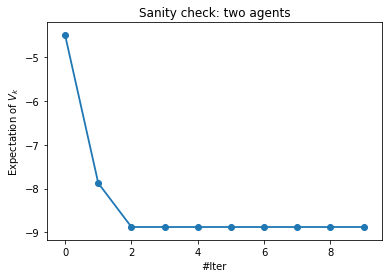

In [192]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 10)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents")
plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_2agents_6nodes.jpg')
plt.show()

In [193]:
def total_return(policy_list):
    # total return for agent 1
    print("--> Start doing total return")
    v1 = []
    v2 = []
    vk = []
    iter = len(policy_list)

    for idx in range(iter):
        # print("debug-->", idx)
        policy = policy_list[idx]

        _, v, _, vl, v_k = policy_evl(R1,policy)
        v1.append(v.copy())
        vk.append(v_k)
#         _, v, _, vl = spg_vi.value_estimate(env, R2, policy)
#         v2.append(v.copy())

#     v1 = np.array(v1)
#     v2 = np.array(v2)
#     x = np.arange(0, iter)
#     print(v1)
#     mean_v = v1.sum(-1)
#     print(mean_v)
#     plt.plot(x, mean_v, linewidth=1.8)
#     plt.scatter(x, mean_v)
#     plt.xlabel('#Iter')
#     plt.ylabel('$V_k$ for agent 1')
#     plt.show()


    x = np.arange(0, iter)
    print(vk)
    plt.plot(x, vk, linewidth=1.8)
    plt.scatter(x, vk)
    plt.xlabel('#Iter')
    plt.ylabel('$V_k$ for agent 1')
    plt.show()

--> Start doing total return
[-24.5, -12.666666666666666, -12.0, -12.0, -12.0, -12.0, -12.0, -12.0, -12.0, -12.0, -12.0]


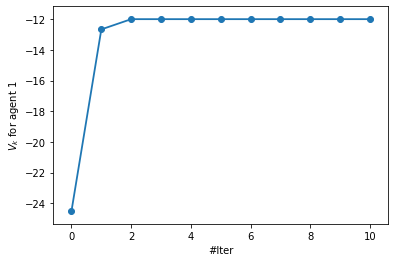

In [194]:
total_return(policy_list)

## Sanity check extension

In [203]:
def P_comp(n, node_N):

    nS = int(2 + ((node_N - 2)/2) * (n + 1))
    print(nS)
    nA = 2**n
    P = dict()
    for s in range(nS):
        P[s] = {a : [] for a in range(nA)}

    for state in range(nS):
        for a in range(nA):
            tmp = []
            prob = 1
            snext = transition[state][a]
            reward = payoff[state][a]
            done = False
            if snext == (nS -1):
                done = True
            # prob, next_state, reward, done
            tmp.extend([(prob, int(snext), reward, done)])
            P[state][a] = tmp
            
    return nS, nA, P


In [204]:
graph = {
    "0": {"1": lambda x : x,            "0": lambda x : 1},
    "1": {"1": lambda x : 0,            "0": lambda x : x},
    "2": {"1": lambda x : 1,            "0": lambda x : x},
    "3": {"1": lambda x : 5,             "0": lambda x: 3*x},
    "4": {"1": lambda x : 2,            "0": lambda x: x},
    "5": {"1": lambda x : x,            "0": 0},
    "6": {"1": lambda x : 1,            "0": 1},
} 

In [205]:
# N = 2
# node_N= 6
# action = action_generator(N)
# state = state_generator2(graph, 2, node_N)
# transition = transition_generator(state, action, 2, node_N)
# payoff = phi_generator2(state, action, transition, graph, node_N, n = 2)
# payoff = -np.array(payoff)


In [206]:
N = 2
node_N= 100

action = action_generator(N)
state = state_generator2(graph, 2, node_N)
transition = transition_generator(state, action, 2, node_N)
payoff = phi_generator2(state, action, transition, graph, node_N, n = 2)
payoff = -np.array(payoff)
# payoff[-1, :] = 0
nS, nA, P =  P_comp(2, 100)

149


In [207]:
policy, V, dl, vl, policy_list, A = VI_congestion(100)

1
debug-> iter=1, delta=8.00000, V=[-2. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -2. -3.  0.]
2
debug-> iter=2, delta=5.00000, V=[ -3.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.
  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.
  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
19
debug-> iter=19, delta=4.00000, V=[-47. -47. -46. -47. -48. -50. -53. -47. -46. -47. -48. -50. -53. -47.
 -46. -47. -48. -50. -53. -47. -46. -47. -48. -50. -53. -47. -46. -47.
 -48. -50. -53. -47. -46. -47. -48. -50. -53. -47. -46. -47. -48. -50.
 -53. -47. -46. -47. -48. -50. -53. -47. -46. -47. -48. -50. -53. -47.
 -46. -47. -48. -50. -53. -47. -46. -47. -48. -50. -53. -47. -46. -47.
 -48. -50. -53. -47. -46. -47. -48. -50. -53. -47. -46. -47. -48. -50.
 -53. -47. -46. -47. -48. -50. -53. -48. -47. -48. -45. -47. -50. -43.
 -42. -43. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
20
debug-> iter=20, delta=4.00000, V=[-48. -51. -50. -51. -49. -51. -54. -51. -50. -51. -49. -51. -54. -51.
 -50. -51. -49. -51. -54. -51. -50. -51. -49. -51. 

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
35
debug-> iter=35, delta=4.00000, V=[-87. -87. -86. -87. -88. -90. -93. -87. -86. -87. -88. -90. -93. -87.
 -86. -87. -88. -90. -93. -87. -86. -87. -88. -90. -93. -87. -86. -87.
 -88. -90. -93. -87. -86. -87. -88. -90. -93. -87. -86. -87. -88. -90.
 -93. -88. -87. -88. -85. -87. -90. -83. -82. -83. -80. -82. -85. -78.
 -77. -78. -75. -77. -80. -73. -72. -73. -70. -72. -75. -68. -67. -68.
 -65. -67. -70. -63. -62. -63. -60. -62. -65. -58. -57. -58. -55. -57.
 -60. -53. -52. -53. -50. -52. -55. -48. -47. -48. -45. -47. -50. -43.
 -42. -43. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
36
debug-> iter=36, delta=4.00000, V=[-88. -91. -90. -91. -89. -91. -94. -91. -90. -91. -89. -91. -94. -91.
 -90. -91. -89. -91. -94. -91. -90. -91. -89. -91. 

debug-> iter=47, delta=4.00000, V=[-117. -117. -116. -117. -118. -120. -123. -118. -117. -118. -115. -117.
 -120. -113. -112. -113. -110. -112. -115. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
48
debug-> iter=48, delta=4.00000, V=[-118. -121. -120. -1

  -10.   -2.   -2.   -3.    0.]
59
debug-> iter=59, delta=0.00000, V=[-124. -123. -122. -123. -120. -122. -125. -118. -117. -118. -115. -117.
 -120. -113. -112. -113. -110. -112. -115. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
60
debug-> iter=60, del

  -10.   -2.   -2.   -3.    0.]
72
debug-> iter=72, delta=0.00000, V=[-124. -123. -122. -123. -120. -122. -125. -118. -117. -118. -115. -117.
 -120. -113. -112. -113. -110. -112. -115. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
73
debug-> iter=73, del

  -10.   -2.   -2.   -3.    0.]
85
debug-> iter=85, delta=0.00000, V=[-124. -123. -122. -123. -120. -122. -125. -118. -117. -118. -115. -117.
 -120. -113. -112. -113. -110. -112. -115. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
86
debug-> iter=86, del

  -10.   -2.   -2.   -3.    0.]
96
debug-> iter=96, delta=0.00000, V=[-124. -123. -122. -123. -120. -122. -125. -118. -117. -118. -115. -117.
 -120. -113. -112. -113. -110. -112. -115. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
97
debug-> iter=97, del

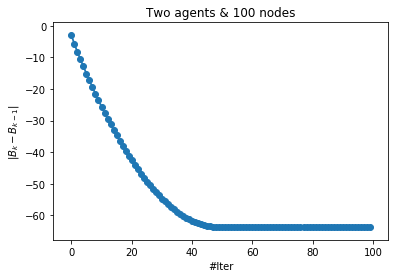

In [208]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 100)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('$|B_{k} - B_{k-1}|$')
plt.title("Two agents & 100 nodes")
plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_2agents_100nodes.jpg')
plt.show()

--> Start doing total return
[-192.5625, -176.69333333333327, -141.4674556213017, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0, -124.0]


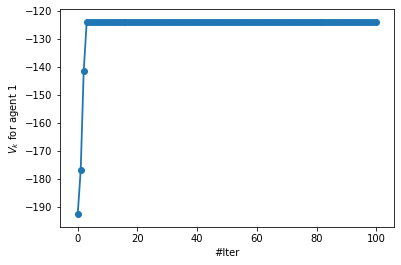

In [209]:
total_return(policy_list)

In [211]:
N = 2
node_N= 20

action = action_generator(N)
state = state_generator2(graph, N, node_N)
transition = transition_generator(state, action, N, node_N)
payoff = phi_generator2(state, action, transition, graph, node_N, n = N)
payoff = -np.array(payoff)
payoff[-1, :] = 0
nS, nA, P =  P_comp(2, 20)

29


In [212]:
policy, V, dl, vl, policy_list, A = VI_congestion(100)

1
debug-> iter=1, delta=8.00000, V=[-2. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -2. -3.  0.]
2
debug-> iter=2, delta=5.00000, V=[ -3.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
3
debug-> iter=3, delta=4.00000, V=[ -7.  -7.  -6.  -7.  -8. -10. -13.  -7.  -6.  -7.  -8. -10. -13.  -7.
  -6.  -7.  -8. -10. -13.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
4
debug-> iter=4, delta=4.00000, V=[ -8. -11. -10. -11.  -9. -11. -14. -11. -10. -11.  -9. -11. -14. -11.
 -10. -11. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
5
debug-> iter=5, delta=4.00000, V=[-12. -12. -11. -12. -13. -15. -18. -12. -11. -12. -13. -15. -18. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
6
debug-> iter=6, delta=4.00000, V=[-13. -16. -15. -16. -14. -16. -19. -16. -15. -16. -15. -17. -20. -13.
 -12

debug-> iter=62, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. -18. -17. -18. -15. -17. -20. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
63
debug-> iter=63, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. -18. -17. -18. -15. -17. -20. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
64
debug-> iter=64, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. -18. -17. -18. -15. -17. -20. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
65
debug-> iter=65, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. -18. -17. -18. -15. -17. -20. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
66
debug-> iter=66, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. -18. -17. -18. -15. -17. -20. -13.
 -12. -13. -10. -12. -15.  -8.  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.
   0.]
67
debug-> iter=67, delta=0.00000, V=[-24. -23. -22. -23. -20. -22. -25. 

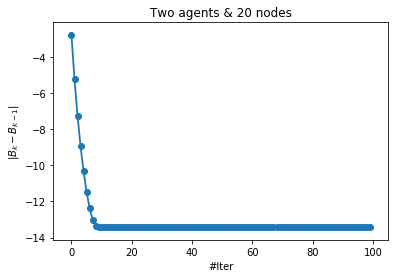

In [213]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 100)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('$|B_k - B_{k-1}|$')
plt.title("Two agents & 20 nodes")
plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_2agents_20nodes.jpg')
plt.show()

--> Start doing total return
[-45.0625, -32.69341563786009, -26.595679012345673, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24.0]


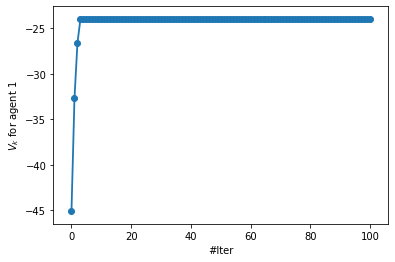

In [155]:
total_return(policy_list)

In [156]:
###########################################################

In [125]:
nS = 149
nA = 4
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 148:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, int(snext), reward, done)])
        P[state][a] = tmp

IndexError: list index out of range

In [126]:
# 5 agents; big
# payoff matrix

N = 5
action = action_generator(N)
state = state_generator(N)
payoff = phi_generator(N, state, action, transition)
payoff = -np.array(payoff)
transition = transition_generator(state, action, N)

nS = len(state)
nA = len(action)


NameError: name 'state_generator' is not defined

In [ ]:
N = 2
node_N= 20

action = action_generator(N)
state = state_generator2(graph, 2, node_N)
transition = transition_generator(state, action, 2, node_N)
payoff = phi_generator2(state, action, transition, graph, node_N, n = 2)
payoff = -np.array(payoff)
payoff[-1, :] = 0
nS, nA, P =  P_comp(2, 20)

In [160]:
n = 4
node_N= 100
action = action_generator(4)
print(len(action))
state = state_generator2(graph, 4, 100)
print(len(state))
transition = transition_generator(state, action, 4, 100)
print(len(transition))
payoff = phi_generator2(state, action, transition, graph, node_N, n = 4)
payoff = -np.array(payoff)
print(len(payoff))
P_comp(n, node_N)

16
247
151
245
247


IndexError: list index out of range

In [ ]:
P_comp(n, node_N

In [146]:
len(transition)

149

In [171]:
payoff

array([[ -2.,  -2.,  -2.,  -3.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -

In [53]:
policy, V, dl, vl, policy_list, A = value_iteration(50)

1
debug-> iter=1, delta=8.00000, V=[-2. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -2. -3.  0.]
2
debug-> iter=2, delta=5.00000, V=[ -3.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.
  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.
  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
16
debug-> iter=16, delta=4.00000, V=[-38. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41.
 -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41.
 -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41.
 -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41.
 -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
17
debug-> iter=17, delta=4.00000, V=[-42. -42. -41. -42. -43. -45. -48. -42. -41. -42. -43. -45. -48. -42.
 -41. -42. -43. -45. -48. -42. -41. -42. -43. -45. 

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
29
debug-> iter=29, delta=4.00000, V=[-72. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72.
 -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72. -71. -72.
 -73. -75. -78. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75.
 -78. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72.
 -71. -72. -73. -75. -78. -73. -72. -73. -70. -72. -75. -68. -67. -68.
 -65. -67. -70. -63. -62. -63. -60. -62. -65. -58. -57. -58. -55. -57.
 -60. -53. -52. -53. -50. -52. -55. -48. -47. -48. -45. -47. -50. -43.
 -42. -43. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
30
debug-> iter=30, delta=4.00000, V=[-73. -76. -75. -76. -74. -76. -79. -76. -75. -76. -74. -76. -79. -76.
 -75. -76. -74. -76. -79. -76. -75. -76. -74. -76. 

43
debug-> iter=43, delta=4.00000, V=[-107. -107. -106. -107. -108. -110. -113. -107. -106. -107. -108. -110.
 -113. -107. -106. -107. -108. -110. -113. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
44
debug-> iter=44, delta=4.00000, V=[-108. -111. -110.

In [ ]:
# 5 agents; big
# payoff matrix

N = 5
action = action_generator(N)
state = state_generator(N)
payoff = phi_generator(N, state, action, transition)
payoff = -np.array(payoff)
transition = transition_generator(state, action, N)

nS = len(state)
nA = len(action)


play around

In [164]:
N = 4
node_N= 20

action = action_generator(N)
print(len(action))
state = state_generator2(graph, 4, node_N)
print(len(state))
transition = transition_generator(state, action, 4, node_N)
print(len(transition))
payoff = phi_generator2(state, action, transition, graph, node_N, n = 4)
payoff = -np.array(payoff)
payoff[-1, :] = 0
nS, nA, P =  P_comp(4, 20)

16
47
31


IndexError: too many indices for array